# EDA + Pipeline Showcase

This notebook:

- Loads `data/processed/articles_clean.csv` and `data/processed/scopes_clean.csv`.
- Runs lightweight EDA (counts, years, text lengths, query distribution).
- Optionally loads and visualizes results from `results/semantic_alignment` 


In [71]:
from __future__ import annotations

import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.dpi"] = 140


def find_repo_root(start: Path) -> Path:
    """Find repo root by walking up until `src/` and `data/` exist."""
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "src").is_dir() and (p / "data").is_dir():
            return p
    return start


ROOT = find_repo_root(Path.cwd())
DATA_DIR = ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
STATS_DIR = DATA_DIR / "stats"
RESULTS_DIR = ROOT / "results"

ROOT

PosixPath('/Users/suleymanyolcu/Desktop/nlp_project')

In [72]:
# Load processed data
articles_path = PROCESSED_DIR / "articles_clean.csv"
scopes_path = PROCESSED_DIR / "scopes_clean.csv"
summary_path = STATS_DIR / "dataset_summary.json"

if not articles_path.exists():
    raise FileNotFoundError(f"Missing: {articles_path}. Run: PYTHONPATH=. python src/data/preprocess.py")
if not scopes_path.exists():
    raise FileNotFoundError(f"Missing: {scopes_path}. Run: PYTHONPATH=. python src/data/preprocess.py")

articles = pd.read_csv(articles_path)
scopes = pd.read_csv(scopes_path)

summary = None
if summary_path.exists():
    summary = json.loads(summary_path.read_text())

articles.shape, scopes.shape

((4000, 8), (1, 2))

## Dataset overview

In [73]:
display(summary)

display(articles.head(3))
display(scopes.head(3))

{'num_articles_total': 4000,
 'num_scopes_total': 1,
 'articles_per_venue_key': {'tpami': 4000},
 'avg_abstract_len': 1516.2895,
 'min_year': 2015,
 'max_year': 2025}

,venue_key,paperId,title,abstract,venue,year,url,query_used
0,tpami,12c1fe76d397aafdab67ac22dc453d057b0045a8,See-Through Vision With Unsupervised Scene Occ...,Among the greatest of the challenges of minima...,IEEE Transactions on Pattern Analysis and Mach...,2021,https://www.semanticscholar.org/paper/12c1fe76...,analysis
1,tpami,d16234da0b4c920752ce5edd447c1b79b739c4d1,Affective Image Content Analysis: Two Decades ...,Images can convey rich semantics and induce va...,IEEE Transactions on Pattern Analysis and Mach...,2021,https://www.semanticscholar.org/paper/d16234da...,data
2,tpami,09437face555fa8d375b6667624834e4795257d7,TV-3DG: Mastering Text-to-3D Customized Genera...,"In recent years, advancements in generative mo...",IEEE Transactions on Pattern Analysis and Mach...,2024,https://www.semanticscholar.org/paper/09437fac...,analysis


,venue_key,scope_text
0,tpami,IEEE Transactions on Pattern Analysis and Mach...


In [74]:
# Basic health checks
print("Columns:", list(articles.columns))
print("Missing paperId:", int(articles["paperId"].isna().sum()))
print("Missing abstract:", int(articles["abstract"].isna().sum()))
print("Unique venues:", articles["venue_key"].nunique())
display(articles["venue_key"].value_counts())

Columns: ['venue_key', 'paperId', 'title', 'abstract', 'venue', 'year', 'url', 'query_used']
Missing paperId: 0
Missing abstract: 0
Unique venues: 1


venue_key
tpami    4000
Name: count, dtype: int64

## Years + volume

year
2015     78
2016    106
2017     90
2018    207
2019    317
2020    523
2021    519
2022    539
2023    577
2024    536
2025    508
Name: count, dtype: int64

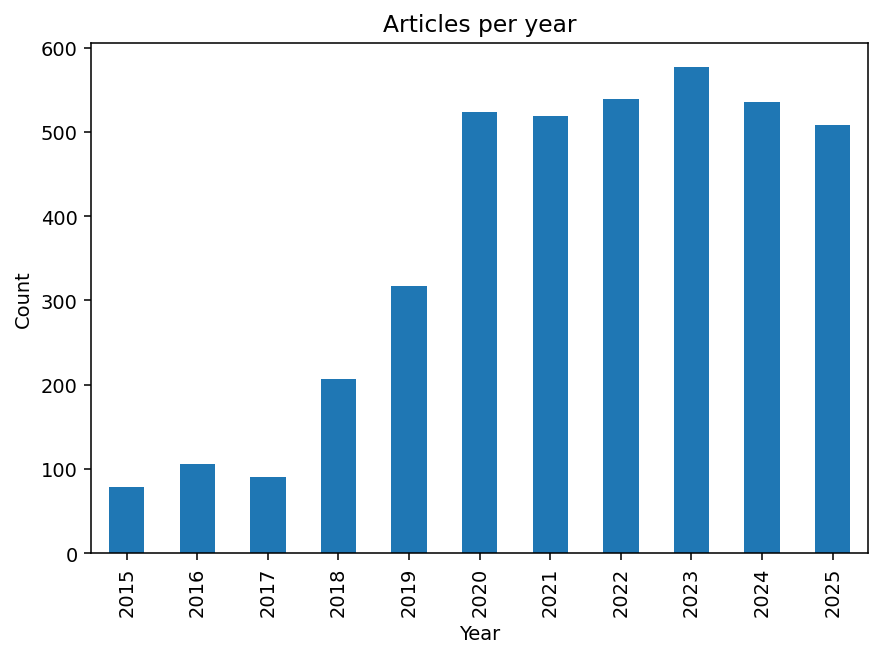

In [75]:
if "year" in articles.columns:
    years = pd.to_numeric(articles["year"], errors="coerce")
    year_counts = years.value_counts().sort_index()
    display(year_counts)

    ax = year_counts.plot(kind="bar", title="Articles per year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No `year` column found.")

## Text length distributions

,abstract_char_len,abstract_word_len
count,4000.000000,4000.000000
mean,1516.289500,201.647250
std,471.531921,42.894362
min,113.000000,17.000000
25%,1275.000000,178.000000
50%,1431.000000,199.000000
75%,1662.250000,220.000000
max,8022.000000,477.000000


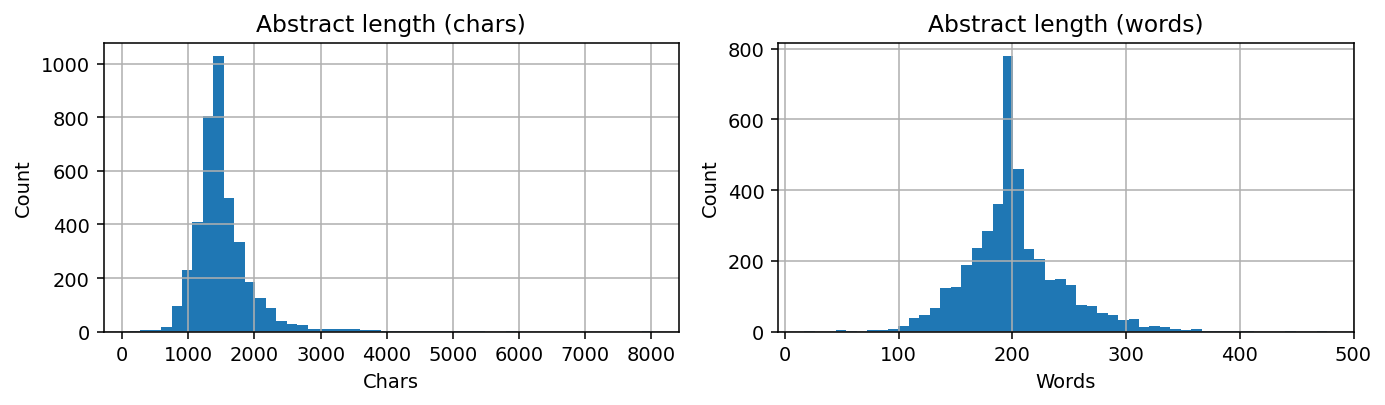

In [76]:
articles = articles.copy()
articles["abstract"] = articles["abstract"].fillna("")
articles["abstract_char_len"] = articles["abstract"].str.len()
articles["abstract_word_len"] = articles["abstract"].str.split().map(len)

display(articles[["abstract_char_len", "abstract_word_len"]].describe())

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
articles["abstract_char_len"].hist(bins=50, ax=ax[0])
ax[0].set_title("Abstract length (chars)")
ax[0].set_xlabel("Chars")
ax[0].set_ylabel("Count")

articles["abstract_word_len"].hist(bins=50, ax=ax[1])
ax[1].set_title("Abstract length (words)")
ax[1].set_xlabel("Words")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

## Query distribution (collection bias check)

If you collected with multiple queries, this shows how many final rows came from each query.

query_used
method      605
study       599
analysis    553
data        500
model       500
approach    500
result      500
system      243
Name: count, dtype: int64

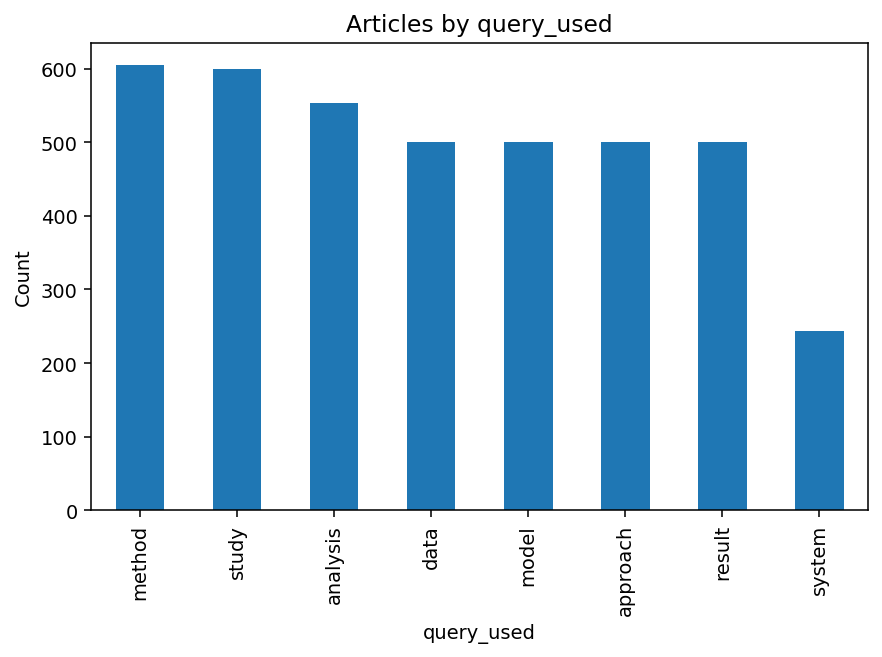

In [77]:
if "query_used" in articles.columns:
    q = articles["query_used"].fillna("")
    vc = q.value_counts()
    display(vc)
    if len(vc) > 1:
        ax = vc.plot(kind="bar", title="Articles by query_used")
        ax.set_xlabel("query_used")
        ax.set_ylabel("Count")
        plt.tight_layout()
        plt.show()
else:
    print("No `query_used` column found.")

## Scope text preview

In [78]:
scopes = scopes.copy()
scopes["scope_text"] = scopes["scope_text"].fillna("")
scopes["scope_char_len"] = scopes["scope_text"].str.len()
display(scopes[["venue_key", "scope_char_len"]])

for _, row in scopes.iterrows():
    print("\n---", row["venue_key"], "---")
    print(row["scope_text"][:800] + ("..." if len(row["scope_text"]) > 800 else ""))

,venue_key,scope_char_len
0,tpami,623



--- tpami ---
IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI) publishes articles on all traditional areas of computer vision and image understanding, all traditional areas of pattern analysis and recognition, and selected areas of machine intelligence, with a particular emphasis on machine learning for pattern analysis. Areas such as techniques for visual search, document and handwriting analysis, medical image analysis, video and image sequence analysis, content-based retrieval of image and video, face and gesture recognition and relevant specialized hardware and/or software architectures are also covered.


## Semantic alignment results (if available)

In [79]:
semantic_dir = RESULTS_DIR / "semantic_alignment"
semantic_scores_path = semantic_dir / "semantic_alignment_scores.csv"

semantic_scores = None
if semantic_scores_path.exists():
    semantic_scores = pd.read_csv(semantic_scores_path)
    display(semantic_scores.head(3))
else:
    print(f"Not found: {semantic_scores_path}")
    print("Run: PYTHONPATH=. python src/semantic_alignment.py")

,paperId,venue_key,title,year,url,embedding_alignment
0,12c1fe76d397aafdab67ac22dc453d057b0045a8,tpami,See-Through Vision With Unsupervised Scene Occ...,2021,https://www.semanticscholar.org/paper/12c1fe76...,0.379684
1,d16234da0b4c920752ce5edd447c1b79b739c4d1,tpami,Affective Image Content Analysis: Two Decades ...,2021,https://www.semanticscholar.org/paper/d16234da...,0.411152
2,09437face555fa8d375b6667624834e4795257d7,tpami,TV-3DG: Mastering Text-to-3D Customized Genera...,2024,https://www.semanticscholar.org/paper/09437fac...,0.281358


,paperId,year,embedding_alignment,title,url
480,e0962f83e2daa04d2a485f43c655a59bfb2d11bb,2018,0.665319,Guest Editorial: The Computational Face,https://www.semanticscholar.org/paper/e0962f83...
856,a7d2c6d88946c90673a31df10884a8d7c8033db2,2019,0.587205,Efficient Learning-Free Keyword Spotting,https://www.semanticscholar.org/paper/a7d2c6d8...
1444,6d902439b736a7546dd8872b307fb760087ca629,2016,0.576798,SIFT Meets CNN: A Decade Survey of Instance Re...,https://www.semanticscholar.org/paper/6d902439...
996,741a7faf9dbefd418cda878c61c5b839ecc02977,2022,0.560696,A Survey on Graph Neural Networks and Graph Tr...,https://www.semanticscholar.org/paper/741a7faf...
2107,945364c8cf1177b19990ae739956b9bfa9de4d41,2024,0.549383,TCFormer: Visual Recognition via Token Cluster...,https://www.semanticscholar.org/paper/945364c8...
1218,5389c9f6c2b2f6b90edf97f96efc47f42b69d2ac,2016,0.544585,Template Matching via Densities on the Roto-Tr...,https://www.semanticscholar.org/paper/5389c9f6...
2231,4b1cdb96a39cf23139a21915ba9e3e0692de8563,2019,0.543815,Bridging the Gap Between Computational Photogr...,https://www.semanticscholar.org/paper/4b1cdb96...
2346,d203076c28587895aa344d088b2788dbab5e82a1,2023,0.538590,Transformer-Based Visual Segmentation: A Survey,https://www.semanticscholar.org/paper/d203076c...
1373,709854730b702ad225090fe8ab9aff8f5eba63b1,2019,0.537705,Towards End-to-End Text Spotting in Natural Sc...,https://www.semanticscholar.org/paper/70985473...
1646,8e9149ab00236d04db23394774e716c4f1d89231,2015,0.531674,An End-to-End Trainable Neural Network for Ima...,https://www.semanticscholar.org/paper/8e9149ab...


,paperId,year,embedding_alignment,title,url
2636,07f350964a196e720b66d6c5a73b08b88b3540bf,2021,0.040558,Community Detection Using Restrained Random-Wa...,https://www.semanticscholar.org/paper/07f35096...
2810,706b41df5b6862bf6fcaf9f74fd916f9829c9bd9,2023,0.046547,Towards Understanding Generalization and Stabi...,https://www.semanticscholar.org/paper/706b41df...
3009,16c4e2fd3c37784dea7a881cc4524dd326f90c46,2025,0.059326,Bidirectional Beta-Tuned Diffusion Model,https://www.semanticscholar.org/paper/16c4e2fd...
119,a7c79c71f83792595c07300a8a51487de12aa2f4,2024,0.066502,Deep Learning with Data Privacy via Residual P...,https://www.semanticscholar.org/paper/a7c79c71...
2693,26a2d2f574e184c219e1cc19b6d8ad1ce922b116,2021,0.070762,Co-VAE: Drug-target binding affinity predictio...,https://www.semanticscholar.org/paper/26a2d2f5...
3265,a808c16fca8c8336753382626c24afef6cc250f3,2020,0.071305,A Causal Framework for Distribution Generaliza...,https://www.semanticscholar.org/paper/a808c16f...
189,04cb96e55e787489a1c6c2df68cfd54a4cbac384,2021,0.080807,Poisoning Attack Against Estimating From Pairw...,https://www.semanticscholar.org/paper/04cb96e5...
2614,c2af287bc644082a07186fb1d9d2d54a88abebad,2022,0.081276,Understanding the Constraints in Maximum Entro...,https://www.semanticscholar.org/paper/c2af287b...
751,3d18bed9b29b9e1a38eac2f7f44b97d9c86d290f,2023,0.083670,Using Zodiacal Light for Spaceborne Calibratio...,https://www.semanticscholar.org/paper/3d18bed9...
750,155f9d92baa2756ee1476634904991b26890db9f,2025,0.097889,A Unified Experience Replay Framework for Spik...,https://www.semanticscholar.org/paper/155f9d92...


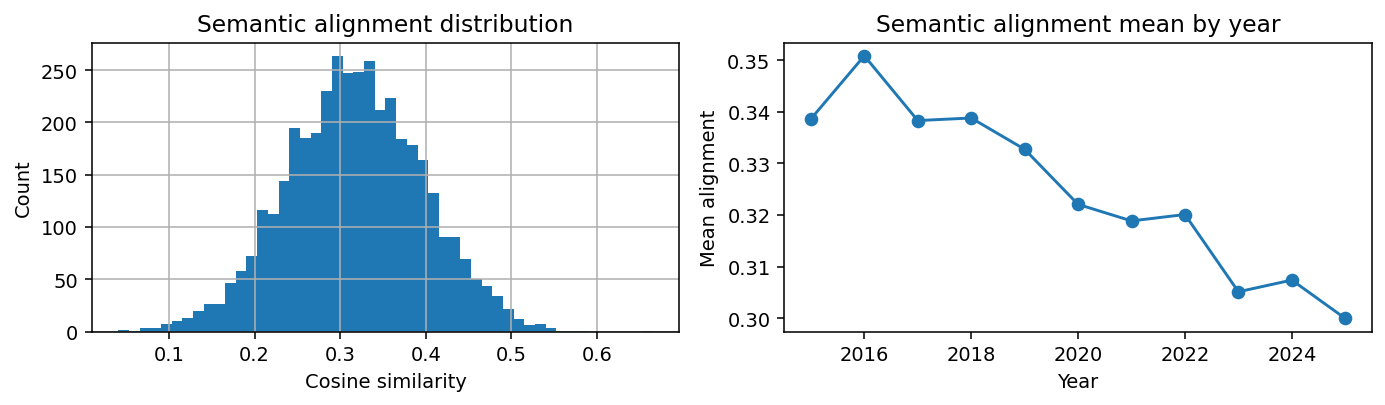

In [80]:
if semantic_scores is not None:
    sem = semantic_scores.copy()
    sem = sem.merge(
        articles[["paperId", "abstract"]],
        on="paperId",
        how="left",
        validate="one_to_one",
    )

    display(sem.sort_values("embedding_alignment", ascending=False).head(10)[["paperId", "year", "embedding_alignment", "title", "url"]])
    display(sem.sort_values("embedding_alignment", ascending=True).head(10)[["paperId", "year", "embedding_alignment", "title", "url"]])

    # Distribution + yearly trend
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    sem["embedding_alignment"].hist(bins=50, ax=ax[0])
    ax[0].set_title("Semantic alignment distribution")
    ax[0].set_xlabel("Cosine similarity")
    ax[0].set_ylabel("Count")

    sem_year = sem.groupby("year", dropna=True)["embedding_alignment"].mean().sort_index()
    sem_year.plot(marker="o", ax=ax[1])
    ax[1].set_title("Semantic alignment mean by year")
    ax[1].set_xlabel("Year")
    ax[1].set_ylabel("Mean alignment")

    plt.tight_layout()
    plt.show()

In [82]:
# Quick qualitative inspection helpers: titles + URLs for extreme papers
if semantic_scores is not None:
    top3 = semantic_scores.nlargest(3, "embedding_alignment")[
        ["title", "url", "embedding_alignment"]
    ]
    bottom3 = semantic_scores.nsmallest(3, "embedding_alignment")[
        ["title", "url", "embedding_alignment"]
    ]

    print("Top 3 (highest semantic alignment)")
    for i, row in top3.iterrows():
        print("-" * 80)
        print(f"Score : {row['embedding_alignment']}")
        print(f"Title : {row['title']}")
        print(f"URL   : {row['url']}")

    print("\nBottom 3 (lowest semantic alignment)")
    for i, row in bottom3.iterrows():
        print("-" * 80)
        print(f"Score : {row['embedding_alignment']}")
        print(f"Title : {row['title']}")
        print(f"URL   : {row['url']}")
else:
    print("No semantic scores loaded. Run: PYTHONPATH=. python src/semantic_alignment.py")


Top 3 (highest semantic alignment)
--------------------------------------------------------------------------------
Score : 0.6653186
Title : Guest Editorial: The Computational Face
URL   : https://www.semanticscholar.org/paper/e0962f83e2daa04d2a485f43c655a59bfb2d11bb
--------------------------------------------------------------------------------
Score : 0.5872051
Title : Efficient Learning-Free Keyword Spotting
URL   : https://www.semanticscholar.org/paper/a7d2c6d88946c90673a31df10884a8d7c8033db2
--------------------------------------------------------------------------------
Score : 0.5767982
Title : SIFT Meets CNN: A Decade Survey of Instance Retrieval
URL   : https://www.semanticscholar.org/paper/6d902439b736a7546dd8872b307fb760087ca629

Bottom 3 (lowest semantic alignment)
--------------------------------------------------------------------------------
Score : 0.040557522
Title : Community Detection Using Restrained Random-Walk Similarity
URL   : https://www.semanticscholar.org/p

## Pipeline commands (terminal)

```bash
export S2_API_KEY="YOUR_KEY"
PYTHONPATH=. python src/data/collect_articles.py
PYTHONPATH=. python src/data/preprocess.py
PYTHONPATH=. python src/semantic_alignment.py --out-dir results/semantic_alignment
```
